# *Dijkstra*: Kürzeste Wege in einem Graphen

Die Suche nach kürzesten Verbindungen in Graphen hat in vielen Bereichen des täglichen Lebens praktische Anwendungen:

- **Navigationssysteme** finden den kürzesten Weg zwischen zwei Orten.
- **Lieferunternehmen** suchen die effizienteste Route für die Zustellung von Waren.
- **Stadtplaner und Verkehrsingenieure** möchten die Verkehrsflüsse optimieren, um Staus zu vermeiden.
- **Routenplanung in Netzwerken** zielt darauf, Datenpakete schnell und effizient zu transportieren.

Bereits 1959 entwickelte der niederländische Mathematiker *E. W. Dijkstra* einen Algorithmus, um in gewichteten ungerichteten Graphen kürzeste Wege zu finden.

Natürlich könnte man alle möglichen Wege zwischen zwei Knoten auflisten, um so den kürzesten Weg zu finden (*brute-force-Ansatz*), doch schon in kleinen Graphen gibt es sehr viele solcher Wege, so dass dieses Verfahren nicht wirklich effizient ist.

Der *Dijkstra-Algorithmus* löst das Problem (erstaunlicherweise) demgegenüber sehr effizient.

In diesem Notebook werden wir diesen Algorithmus an einem Beispiel durchführen.

Dazu benutzten wir
- die Programmiersprache **Python** (in der Version 3.10)
- die **Jupyter-Notebook-Umgebung**
- eine spezielle Python-Bibliothek `networkx`, mit der wir sehr leicht gewichtete Graphen implementieren können.
- eine eigene Python-Bibliothek `nrw_graph`, die auf `networkx` basiert, die den Umgang mit Graphen methodisch-didaktisch vereinfacht.

## Begriffsklärung: ***Graphen***

Ein ***Graph*** ist eine abstrakte mathematische Struktur, die aus einer Menge von Knoten (engl.: vertices) und einer Menge von Kanten (engl. edges) besteht. Die Knoten stellen dabei Objekte dar, während die Kanten die Beziehungen zwischen diesen Objekten repräsentieren. 

Graphen werden in vielen Bereichen der Mathematik, Informatik, Ingenieurwissenschaften, Biologie und anderen Wissenschaften verwendet, um komplexe Systeme zu modellieren und zu analysieren. 

Es gibt verschiedene Arten von Graphen:
- gerichtete und ungerichtete Graphen
  - Haben die Kanten eine Richtung (Einbahnstraßen) oder ist das für die aktuelle Anwendung unerheblich?
- gewichtete und ungewichtete Graphen
  - Haben die Kanten z.B. eine Länge oder spielt das keine Rolle für die aktuelle Anwendung?

Die Graphentheorie beschäftigt sich mit der Untersuchung von Graphen und deren Eigenschaften.

Hier sieht man Beispiele für die unterschiedlichen Typen von Graphen:

- ungerichtet, ungewichtet:
  - Beispiel: Die Knoten sind Personen, die genau dann verbunden sind, wenn sie sich kennen.

<td> 
    <img src="Bilder\undir_unweight_graph.png" alt="ungerichtet, ungewichtet" 
         style="width: 300px; float: left;"  hspace=40 /> 
</td>

- ungerichtet, gewichtet:
  - Beispiel: Die Knoten sind Städte, die Kanten sind (in beiden Richtungen befahrbare) Straßen mit angegebener Länge

<td> 
    <img src="Bilder\undir_weight_graph.png" alt="ungerichtet, gewichtet" 
         style="width: 400px; float: left;" hspace=40/>
</td>

- gerichtet, ungewichtet:
  - Beispiel: Die Knoten sind Personen. Eine gerichtete Kante verläuft von X nach Y, wenn die Person X die Person Y mag.

<td> 
    <img src="Bilder\dir_unweight_graph.png" alt="gerichtet, ungewichtet" 
         style="width: 300px; float: left;"  hspace=40 /> 
</td>

- gerichtet, gewichtet:
  - Beispiel: Die Knoten sind Hafenstädte. Eine Kante von X nach Y mit Gewicht g besagt, dass von X nach Y ein Container mit Gewicht g verschifft wird.

<td> 
    <img src="Bilder\dir_weight_graph.jpeg" alt="gerichtet, gewichtet" 
         style="width: 300px; float: left;" hspace=40/>
</td>


In diesem Abschnitt werden ausschließlich **ungerichtete**, **gewichtete** Graphen betrachtet. Ggf. werden in späteren Abschnitten auch andere Typen behandelt.

Weitere Einschränkungen:
- Es gibt in den hier betrachteten Graphen keine *Schlingen* (eine Kante, deren Anfangs- und Endkonten identisch sind).
- Es gibt keine *Mehrfachkanten* (mehrere Kanten zwischen gleichen Knoten).
- Die Graphen haben nur *positive Kantengewichte*.

## Notwendige Bibliotheken importieren

In [1]:
import networkx as nx
import nrw_graph as ng

# pandas ist eine Bibliothek für Python u.a. zur Verarbeitung von Daten.
import pandas as pd

# Bibliothek, z.B. um Daten graphisch darzustellen.
import matplotlib.pyplot as plt

## Dokumentation der Bibliothek `nrw_graph`

Um Graphenalgorithmen mit Hilfe von Python implementieren zu können, gibt es die Bibliothek `networkx`.

Darauf aufbauend wurde die Bibliothek `nrw_graph` geschrieben, in der einfach zu nutzende Funktionen implementiert sind.

Die Dokumentation der Funktionen dieser Klasse können auf Wunsch eingesehen werden. Dazu müssen Sie den Kommentar der folgende Zelle entfernen, dann die Zelle aktivieren:

In [2]:
# help("nrw_graph")

## Graph (Kanten, Knoten, Gewicht) aus einer Datei einlesen

Ein *gewichteter Graph* wird beschrieben durch die Angabe der zu dem Graphen gehörenden Kanten. Eine Kante ist dabei ein Objekt, in dem die Namen der beiden Endknoten sowie das Gewicht der Kante (in unserem Beispiel die Länge) enthalten sind.

Da die Knoten, die der Graph enthält, nicht explizit angegeben werden, sondern sich aus den Endknoten der Kanten ergeben, kann man auf diese Weise keine Graphen mit isolierten Knoten erzeugen. Jedoch ist das für unser Beispiel nicht tragisch, da von und zu isolierten Knoten sicherlich kein Weg führt.

Die für einen Graphen notwendigen Daten sollten sich in einer CSV-Datei befinden. Eine solche Datei enthält die Daten (also die Information über eine Kante) zeilenweise, wobei die erste Zeile ein Art Überschrift ist.

Jede Zeile enthält - in der Regel duch Kommata oder Semikolon getrennt - die Werte der jeweiligen Attribute:

- Name des Startknoten
- Name des Zielknoten
- Länge der Kante

Dabei sind in diesem Zusammenhang die Begriffe *Start* und *Ziel* ggf. missverständlich, da die Graphen, die hier benutzt werden, ungerichtet sind; gibt es also eine Kante von A nach B, die in dem Datensatz  angegeben ist, gibt es automatisch auch die Kante von B nach A gleicher Länge, ohne dass sie explizit in den Datensätzen auftaucht.

In [3]:
#df_staedte = pd.read_csv("staedte.txt", sep=",")
df_staedte = pd.read_csv("stdt.txt", sep=",")

# Hier werden aus Gründen der Übersichtlichkeit 
# nur die ersten 10 Datensätze in einer Tabelle gezeigt.
display(df_staedte.head(10)) #

,Start,Ziel,Entfernung
0,KI,SN,160
1,KI,HH,97
2,KI,HB,211
3,HH,HB,126
4,SN,HH,110
5,HAM,MS,70
6,MS,HB,120
7,HB,H,127
8,HH,H,159
9,BI,H,90


## Der Graph wird aus den Daten konstruiert

In [4]:
# Ein neuer leerer Graph
autobahn = ng.nrw_graph()

# In diesen Graph werden die Informationen aus der Datei eingetragen
autobahn.graphEinlesen("stdt.txt", sep=",")

## Zeig mal den Graphen

Wenn man möchte, kann man den Graphen visualisieren. 

Doch **Vorsicht**: 

- Die Daten in der Datei enthalten keine Angaben über die Lage der Knoten zueinander. Damit ein einigermaßen realistisches Bild der Autobahnverbindungen entstehen kann, wurden in dem folgenden Python-Programm die Längen- und Breitengrade der Städte in Form eines Dictionaries angegeben.

Diese Darstellung ist nur eine nette Spielerei, um die Fähigkeit der Bibliothek zu demonstrieren! In den folgenden Abschnitten, in denen es um kürzeste Verbindungen geht, spielen diese Angaben keine Rolle mehr. 

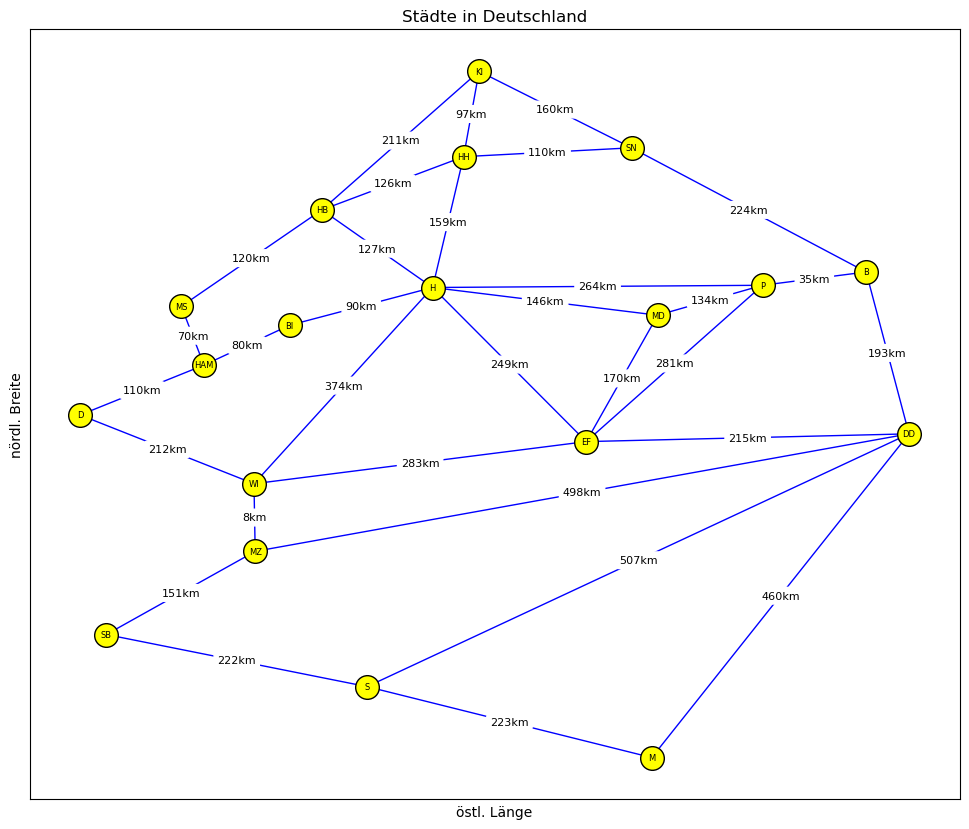

In [65]:
# explicitly set positions
# (Längengrad östl. , Breitengrad nördl.)
pos = {'KI' : (10.12, 54.32), 
       'SN' : (11.40, 53.63), 
       'HH' : ( 9.99, 53.55), 
       'HB' : ( 8.80, 53.07), 
       'BI' : ( 8.53, 52.03), 
       'H'  : ( 9.73, 52.37), 
       'MD' : (11.62, 52.12), 
       'B'  : (13.37, 52.51), 
       'D'  : ( 6.77, 51.22), 
       'MZ' : ( 8.24, 49.99), 
       'EF' : (11.02, 50.98), 
       'DD' : (13.73, 51.05), 
       'SB' : ( 6.99, 49.24), 
       'S'  : ( 9.18, 48.77), 
       'M'  : (11.57, 48.13), 
       'HAM': ( 7.81, 51.67), 
       
# Die folgenden Einträge benutzen die korrekten Werte: 
#       'P'  : (13.06, 52.39), # orig
#       'MS' : ( 7.62, 51.96), # orig
#       'WI' : ( 8.23, 50.07), # orig 

# Die folgenden Einträge benutzen leicht verschobene Werte, 
# damit sich die Knoten in der Graphik nicht überlappen!
       'P'  : (12.50, 52.39), 
       'MS' : ( 7.62, 52.20), 
       'WI' : ( 8.23, 50.60),  
      }

kantenNamen = {(s,z):str(autobahn.getKantenAttribut(s,z,"gewicht")) + "km" for (s,z) in autobahn.alleKanten()}

node_options = {
    "node_color": "yellow",
    "edgecolors": "black",
    "node_size": 290,
    "linewidths": 1,
                }
edge_options = {
    "edge_color": "blue",
    "width": 1,
}

label_options = {
    "font_size": 6, 
    "font_color" : "black",
}

edge_label_options = {
    "font_size": 8, 
    "font_color" : "black",
    "label_pos" : 0.5,
    "edge_labels" : kantenNamen,
    "rotate" : False,
}

# nodes:
nx.draw_networkx_nodes(autobahn, pos, **node_options)

# edges:
nx.draw_networkx_edges(autobahn, pos, **edge_options)

# labels:
nx.draw_networkx_labels(autobahn, pos, **label_options)

# edge_labels:
nx.draw_networkx_edge_labels(autobahn, pos, **edge_label_options)

ax = plt.gca()
ax.set_xlabel("östl. Länge")
ax.set_ylabel("nördl. Breite")
ax.set_title("Städte in Deutschland")
ax.margins(0.01)

plt.rcParams["figure.figsize"] = (12, 10)
plt.axis("on")
plt.show()

## Kontrolle: Hat das Einlesen der Daten geklappt?

In [6]:
autobahn.alleKanten()

[('KI', 'SN'),
 ('KI', 'HH'),
 ('KI', 'HB'),
 ('SN', 'HH'),
 ('SN', 'B'),
 ('HH', 'HB'),
 ('HH', 'H'),
 ('HB', 'MS'),
 ('HB', 'H'),
 ('HAM', 'MS'),
 ('HAM', 'D'),
 ('HAM', 'BI'),
 ('H', 'BI'),
 ('H', 'WI'),
 ('H', 'EF'),
 ('H', 'MD'),
 ('H', 'P'),
 ('D', 'WI'),
 ('WI', 'MZ'),
 ('WI', 'EF'),
 ('MZ', 'SB'),
 ('MZ', 'DD'),
 ('SB', 'S'),
 ('EF', 'MD'),
 ('EF', 'P'),
 ('EF', 'DD'),
 ('MD', 'P'),
 ('P', 'B'),
 ('B', 'DD'),
 ('DD', 'S'),
 ('DD', 'M'),
 ('S', 'M')]

In [7]:
for kante in autobahn.alleKanten():
    start = kante[0]
    ziel = kante[1]
    print(start.ljust(12), " -- ", ziel.ljust(12), ":", autobahn.getKantenGewicht(start, ziel))

KI            --  SN           : 160
KI            --  HH           : 97
KI            --  HB           : 211
SN            --  HH           : 110
SN            --  B            : 224
HH            --  HB           : 126
HH            --  H            : 159
HB            --  MS           : 120
HB            --  H            : 127
HAM           --  MS           : 70
HAM           --  D            : 110
HAM           --  BI           : 80
H             --  BI           : 90
H             --  WI           : 374
H             --  EF           : 249
H             --  MD           : 146
H             --  P            : 264
D             --  WI           : 212
WI            --  MZ           : 8
WI            --  EF           : 283
MZ            --  SB           : 151
MZ            --  DD           : 498
SB            --  S            : 222
EF            --  MD           : 170
EF            --  P            : 281
EF            --  DD           : 215
MD            --  P            : 134
P      

## Einige Hilfsfunktionen

### Informationen über Knoten; Markieren von Knoten

Wir betrachten einmal einen Knoten K des Graphen. In vielen Situationen ist es wichtig zu wissen, von welchem Knoten V (der Vorgängerknoten von K) man zu K kommt und wie weit es dabei ist. 
- Manchmal möchte man wissen, wie weit der es von V zu K ist, 
- in anderen Fällen ist die Entfernung vom Start über V zu K interessant.

Insgesamt kann man die drei Informationen 
- Name von K
- Name des Vorgängerknoten
- Entfernung zu K

als 3-elementige Liste verwalten, die als Information genutzt wird.

### Knoten können *besucht* werden

Knoten können ein boolsches Flag (`True` oder `False`) haben. 

Ein Knoten K nennen wir *besucht*, wenn bekannt ist, wie lang der kürzeste Weg vom Start zu K ist. 
In einem Graphen sind zunächst alle Knoten unbesucht, haben also die Flagge `False`.

Ein besuchter Knoten hat die Flagge `True`. Wenn Knoten besucht sind, haben sie eine Marke in Form einer 3-elementigen Liste (s.o.).

Die folgende Funktion erzeugt eine Liste aller besuchten Knoten (genauer der zugehörigen Knotenmarken):

In [8]:
def alleBesuchtenKnoten():
    alle = []
    for knoten in autobahn.alleKnoten():
        if autobahn.knotenIstBesucht(knoten):
            (ueber, lang) = autobahn.getKnotenMarke(knoten)
            alle.append([knoten,ueber, lang])
    return alle

In [9]:
# Eine Hilfsfunktion, damit man die später die Liste von Kanten (s.o.) sortieren kann.
# Die einträge in einer solchen Liste sind ebenfalls Listen der Form [über,ziel,entfernung] 
def entfernung (liste):
    return liste[2]

### Wir finden *Folgeknoten*

Für jeden Knoten K im Graphen ist es wichtig zu wissen, welche Knoten F von K aus direkt zu erreichen sind. Dabei werden die drei Informationen
- Name von K
- Name von F
- Länge der Kante K-F

in Form einer 3-elementigen Liste (s.o.) verwaltet.

Die folgende Funktion liefert eine Liste aller möglichen Kanten von K aus zu Folgeknoten (bzw. deren Kanteninfos):

In [10]:
def kantenVon(von):
    kanten = []
    for (s,z) in autobahn.alleKanten():
        if s == von:
            l = autobahn.getKantenGewicht(s, z)
            kanten.append([s, z, l])
        elif z == von:
            l = autobahn.getKantenGewicht(s, z)
            kanten.append([z, s, l])

    return kanten

### Wir finden *lokale Schnittkanten*

Betrachten wir jetzt einen bereits besuchten Knoten K.

Im Gegensatz zur vorigen Funktion `kantenVon` inetressieren wir uns jetzt nur für solche Folgeknoten F, die noch nicht besucht sind. Eine Kante von K zu dem unbesuchten Folgeknoten F nennen wir eine *lokale Schnittkante*.

Zu dem Folgeknoten F haben wir also (erneut in Form einer 3-elementigen Liste) die Informationen:
- Name von K
- Name von F
- Länge der Kante K-F

Die folgende Funktion liefert eine Liste aller möglichen Schnittkanten von K aus zu Folgeknoten (bzw. deren Kanteninfos):

In [11]:
def lokaleSchnittkantenVon(von):
    kanten = []
    for (s,z) in autobahn.alleKanten():
        if s == von and not autobahn.knotenIstBesucht(z):
            l = autobahn.getKantenGewicht(s, z)
            kanten.append([s, z, l])
        elif z == von and not autobahn.knotenIstBesucht(s):
            l = autobahn.getKantenGewicht(s, z)
            kanten.append ([z,s, l])

    return kanten

### Wir finden *Schnittkanten*

Die Schnittkanteninformationen, die wir in der vorigen Funktion erzeugt haben, sind jedoch für unsere Zwecke nicht zielführend, da zu einem Folgeknoten F von K nicht die Kantenlänge K-F, sondern die Weglänge vom Start über K zu F wichtig ist.

Eine solche Kante nennen wir *Schnittkante*.

Also erzeugen wir zu jedem unbesuchten Folgeknoten F die Informationen

- Name von K
- Name von F
- Länge des Weges vom Start über K zu F

Die folgende Funktion erzeugt eine Liste aller Schnittkanteninformationen im Graph. Es werden also zu allen besuchten Knoten K die Schnittkanteninfos erzeugt:

In [12]:
def alleSchnittkanten():
    kanten = []
    for (s,z) in autobahn.alleKanten():
        if autobahn.knotenIstBesucht(s) and not autobahn.knotenIstBesucht(z):
            l = autobahn.getKantenGewicht(s, z)
            (ueber, weit) = autobahn.getKnotenMarke(s)
            l += weit
            kanten.append ([s, z, l])
        elif autobahn.knotenIstBesucht(z) and not autobahn.knotenIstBesucht(s):
            l = autobahn.getKantenGewicht(z, s)
            (ueber, weit) = autobahn.getKnotenMarke(z)
            l += weit
            kanten.append([z, s, l])

    return kanten

### Markierung von besuchten Knoten

Wenn ein Knoten K besucht ist, möchte man den kürzesten Weg vom Start zu K kennen. 

Kennt man zu jedem besuchten Knoten den Vorgänger auf dem kürzesten Weg, kann der kürzeste Weg rückwärts rekonstruiert werden.

Also markieren wir jeden besuchten Knoten K mit einem Tupel, bestehend aus:

- Name des Vorgängers V
- Länge des kürzesten Weges vom Start über V zu K

## Dijkstra "Zu Fuß" lösen: Von Berlin nach München

In [13]:
startknoten = "B"
zielknoten = "M"

### Berlin ist bereits besucht!

Zunächst eine Trivialität:
- Möchte man von Berlin nach Berlin reisen, so ist die kürzeste Verbindung über Berlin mit einer Länge von 0.0

Also wird Berlin mit einer Flagge und eine Marke der Form (ueber, laenge) versehen:

In [14]:
autobahn.besucheKnoten("B")
autobahn.markiereKnoten("B", ("B", 0.0))

Jetzt kann man sich alle geflaggten Knoten mit ihren Marken ansehen.

**Schau dir dazu die entsprechende Hilfsfunktion weiter oben an!**

In [15]:
alleBesuchtenKnoten()

[['B', 'B', 0.0]]

### Welcher Ort ist Berlin am nächsten?

**Schau dir auch dazu die entsprechende Hilfsfunktion weiter oben an!**

In [16]:
kantenVon("B")

[['B', 'SN', 224], ['B', 'P', 35], ['B', 'DD', 193]]

Also ist Potsdam derjenige Ort, der von Berlin am nächsten liegt, so dass wir
Potsdam als besucht betrachten können.

Will man also von Berlin nach Potsdam, dann (mal wieder eine Trivialität) fährt man über Berlin; die Strecke hat
eine Länge von 35.0

Diese Informationen trägt man ein:

In [17]:
autobahn.besucheKnoten("P")
autobahn.markiereKnoten("P", ("B", 35.0))

Zur Kontrolle:

In [18]:
alleBesuchtenKnoten()

[['P', 'B', 35.0], ['B', 'B', 0.0]]

### Jetzt geht's weiter: von Berlin oder von Potsdam?

Man kann jetzt entweder 
- von Berlin aus direkt 
- oder von Berlin über Potsdam 

weiterfahren zu einem Ort, der möglichst nahe ist.

***Definition*** Kanten, die einen besuchten mit einem unbesuchten Ort verbinden, nennt man **Schnittkanten**

Also suchen wir zunächst alle Orte (mitsamt Entfernungen), die von Berlin direkt erreichbar sind. 
Dabei lassen wir natürlich den bereits besuchten Ort Potsdam aus:

In [19]:
lokaleSchnittkantenVon("B")

[['B', 'SN', 224], ['B', 'DD', 193]]

Jedoch müssen wir auch Schnittkanten - ausgehend von Potsdam - betrachten. Dabei ist aber zu beachten, dass ein Ort X, der von Potsdam direkt erreichbar ist, eine Gesamtroute der Form 

- Berlin - Potsdam - X

hat, so dass die Weglänge sich dann zusammensetzt aus der Länge von (Berlin - Potsdam) und der Länge (Potsdam - X).

In [20]:
alleSchnittkanten()

[['B', 'SN', 224.0],
 ['P', 'H', 299.0],
 ['P', 'EF', 316.0],
 ['P', 'MD', 169.0],
 ['B', 'DD', 193.0]]

Das ergibt also insgesamt 5 Schnittkanten:

1. 'Berlin' - 'Schwerin', 224.0,
1. 'Potsdam' - 'Hannover', 299.0,
1. 'Potsdam' - 'Erfurt', 316.0,
1. 'Potsdam' - 'Magdeburg', 169.0,
1. 'Berlin' - 'Dresden', 193.0

und damit 5 Routen von Berlin aus:

1. 'Berlin', 'Schwerin', 224.0,
1. 'Berlin' - 'Potsdam - 'Hannover', 299.0,
1. 'Berlin' - 'Potsdam' - 'Erfurt', 316.0,
1. 'Berlin' - 'Potsdam' - 'Magdeburg', 169.0,
1. 'Berlin', 'Dresden', 193.0


Die Route nach Magdeburg (über Potsdam) ist also die kürzeste. Das müssen wir jetzt eintragen:

In [21]:
autobahn.besucheKnoten("MD")
autobahn.markiereKnoten("MD", ("P", 169.0))

Auch hier die Kontrolle:

In [22]:
alleBesuchtenKnoten()

[['MD', 'P', 169.0], ['P', 'B', 35.0], ['B', 'B', 0.0]]

### Jetzt ist alles klar!?

***Aufgabe***: 

Setze das Verfahren fort.

## Ab hier die schrittweise Lösung

***Also bitte nur ansehen, falls nötig!***

In [23]:
alleSchnittkanten()

[['B', 'SN', 224.0],
 ['MD', 'H', 315.0],
 ['P', 'H', 299.0],
 ['MD', 'EF', 339.0],
 ['P', 'EF', 316.0],
 ['B', 'DD', 193.0]]

In [24]:
autobahn.besucheKnoten("DD")
autobahn.markiereKnoten("DD", ("B", 193.0))

In [25]:
alleBesuchtenKnoten()

[['MD', 'P', 169.0], ['P', 'B', 35.0], ['B', 'B', 0.0], ['DD', 'B', 193.0]]

In [26]:
alleSchnittkanten()

[['B', 'SN', 224.0],
 ['MD', 'H', 315.0],
 ['P', 'H', 299.0],
 ['DD', 'MZ', 691.0],
 ['MD', 'EF', 339.0],
 ['P', 'EF', 316.0],
 ['DD', 'EF', 408.0],
 ['DD', 'S', 700.0],
 ['DD', 'M', 653.0]]

In [27]:
autobahn.besucheKnoten("SN")
autobahn.markiereKnoten("SN", ("B", 224.0))

In [28]:
alleBesuchtenKnoten()

[['SN', 'B', 224.0],
 ['MD', 'P', 169.0],
 ['P', 'B', 35.0],
 ['B', 'B', 0.0],
 ['DD', 'B', 193.0]]

In [29]:
alleSchnittkanten()

[['SN', 'KI', 384.0],
 ['SN', 'HH', 334.0],
 ['MD', 'H', 315.0],
 ['P', 'H', 299.0],
 ['DD', 'MZ', 691.0],
 ['MD', 'EF', 339.0],
 ['P', 'EF', 316.0],
 ['DD', 'EF', 408.0],
 ['DD', 'S', 700.0],
 ['DD', 'M', 653.0]]

In [30]:
autobahn.besucheKnoten("H")
autobahn.markiereKnoten("H", ("P", 299.0))

In [31]:
alleBesuchtenKnoten()

[['SN', 'B', 224.0],
 ['H', 'P', 299.0],
 ['MD', 'P', 169.0],
 ['P', 'B', 35.0],
 ['B', 'B', 0.0],
 ['DD', 'B', 193.0]]

In [32]:
alleSchnittkanten()

[['SN', 'KI', 384.0],
 ['SN', 'HH', 334.0],
 ['H', 'HH', 458.0],
 ['H', 'HB', 426.0],
 ['H', 'BI', 389.0],
 ['H', 'WI', 673.0],
 ['H', 'EF', 548.0],
 ['DD', 'MZ', 691.0],
 ['MD', 'EF', 339.0],
 ['P', 'EF', 316.0],
 ['DD', 'EF', 408.0],
 ['DD', 'S', 700.0],
 ['DD', 'M', 653.0]]

In [33]:
autobahn.besucheKnoten("EF")
autobahn.markiereKnoten("EF", ("P", 316.0))

In [34]:
alleBesuchtenKnoten()

[['SN', 'B', 224.0],
 ['H', 'P', 299.0],
 ['EF', 'P', 316.0],
 ['MD', 'P', 169.0],
 ['P', 'B', 35.0],
 ['B', 'B', 0.0],
 ['DD', 'B', 193.0]]

In [35]:
alleSchnittkanten()

[['SN', 'KI', 384.0],
 ['SN', 'HH', 334.0],
 ['H', 'HH', 458.0],
 ['H', 'HB', 426.0],
 ['H', 'BI', 389.0],
 ['H', 'WI', 673.0],
 ['EF', 'WI', 599.0],
 ['DD', 'MZ', 691.0],
 ['DD', 'S', 700.0],
 ['DD', 'M', 653.0]]

In [36]:
autobahn.besucheKnoten("HH")
autobahn.markiereKnoten("HH", ("SN", 334.0))

In [37]:
alleBesuchtenKnoten()

[['SN', 'B', 224.0],
 ['HH', 'SN', 334.0],
 ['H', 'P', 299.0],
 ['EF', 'P', 316.0],
 ['MD', 'P', 169.0],
 ['P', 'B', 35.0],
 ['B', 'B', 0.0],
 ['DD', 'B', 193.0]]

In [38]:
alleSchnittkanten()

[['SN', 'KI', 384.0],
 ['HH', 'KI', 431.0],
 ['HH', 'HB', 460.0],
 ['H', 'HB', 426.0],
 ['H', 'BI', 389.0],
 ['H', 'WI', 673.0],
 ['EF', 'WI', 599.0],
 ['DD', 'MZ', 691.0],
 ['DD', 'S', 700.0],
 ['DD', 'M', 653.0]]

In [39]:
autobahn.besucheKnoten("KI")
autobahn.markiereKnoten("KI", ("SN", 384.0))

In [40]:
alleBesuchtenKnoten()

[['KI', 'SN', 384.0],
 ['SN', 'B', 224.0],
 ['HH', 'SN', 334.0],
 ['H', 'P', 299.0],
 ['EF', 'P', 316.0],
 ['MD', 'P', 169.0],
 ['P', 'B', 35.0],
 ['B', 'B', 0.0],
 ['DD', 'B', 193.0]]

In [41]:
alleSchnittkanten()

[['KI', 'HB', 595.0],
 ['HH', 'HB', 460.0],
 ['H', 'HB', 426.0],
 ['H', 'BI', 389.0],
 ['H', 'WI', 673.0],
 ['EF', 'WI', 599.0],
 ['DD', 'MZ', 691.0],
 ['DD', 'S', 700.0],
 ['DD', 'M', 653.0]]

In [42]:
autobahn.besucheKnoten("BI")
autobahn.markiereKnoten("BI", ("H", 389.0))

In [43]:
alleBesuchtenKnoten()

[['KI', 'SN', 384.0],
 ['SN', 'B', 224.0],
 ['HH', 'SN', 334.0],
 ['H', 'P', 299.0],
 ['BI', 'H', 389.0],
 ['EF', 'P', 316.0],
 ['MD', 'P', 169.0],
 ['P', 'B', 35.0],
 ['B', 'B', 0.0],
 ['DD', 'B', 193.0]]

In [44]:
alleSchnittkanten()

[['KI', 'HB', 595.0],
 ['HH', 'HB', 460.0],
 ['H', 'HB', 426.0],
 ['BI', 'HAM', 469.0],
 ['H', 'WI', 673.0],
 ['EF', 'WI', 599.0],
 ['DD', 'MZ', 691.0],
 ['DD', 'S', 700.0],
 ['DD', 'M', 653.0]]

In [45]:
autobahn.besucheKnoten("HB")
autobahn.markiereKnoten("HB", ("H", 426.0))

In [46]:
alleBesuchtenKnoten()

[['KI', 'SN', 384.0],
 ['SN', 'B', 224.0],
 ['HH', 'SN', 334.0],
 ['HB', 'H', 426.0],
 ['H', 'P', 299.0],
 ['BI', 'H', 389.0],
 ['EF', 'P', 316.0],
 ['MD', 'P', 169.0],
 ['P', 'B', 35.0],
 ['B', 'B', 0.0],
 ['DD', 'B', 193.0]]

In [47]:
alleSchnittkanten()

[['HB', 'MS', 546.0],
 ['BI', 'HAM', 469.0],
 ['H', 'WI', 673.0],
 ['EF', 'WI', 599.0],
 ['DD', 'MZ', 691.0],
 ['DD', 'S', 700.0],
 ['DD', 'M', 653.0]]

In [48]:
autobahn.besucheKnoten("HAM")
autobahn.markiereKnoten("HAM", ("BI", 469.0))

In [49]:
alleBesuchtenKnoten()

[['KI', 'SN', 384.0],
 ['SN', 'B', 224.0],
 ['HH', 'SN', 334.0],
 ['HB', 'H', 426.0],
 ['HAM', 'BI', 469.0],
 ['H', 'P', 299.0],
 ['BI', 'H', 389.0],
 ['EF', 'P', 316.0],
 ['MD', 'P', 169.0],
 ['P', 'B', 35.0],
 ['B', 'B', 0.0],
 ['DD', 'B', 193.0]]

In [50]:
alleSchnittkanten()

[['HB', 'MS', 546.0],
 ['HAM', 'MS', 539.0],
 ['HAM', 'D', 579.0],
 ['H', 'WI', 673.0],
 ['EF', 'WI', 599.0],
 ['DD', 'MZ', 691.0],
 ['DD', 'S', 700.0],
 ['DD', 'M', 653.0]]

In [51]:
autobahn.besucheKnoten("MS")
autobahn.markiereKnoten("MS", ("HAM", 539.0))

In [52]:
alleBesuchtenKnoten()

[['KI', 'SN', 384.0],
 ['SN', 'B', 224.0],
 ['HH', 'SN', 334.0],
 ['HB', 'H', 426.0],
 ['HAM', 'BI', 469.0],
 ['MS', 'HAM', 539.0],
 ['H', 'P', 299.0],
 ['BI', 'H', 389.0],
 ['EF', 'P', 316.0],
 ['MD', 'P', 169.0],
 ['P', 'B', 35.0],
 ['B', 'B', 0.0],
 ['DD', 'B', 193.0]]

In [53]:
alleSchnittkanten()

[['HAM', 'D', 579.0],
 ['H', 'WI', 673.0],
 ['EF', 'WI', 599.0],
 ['DD', 'MZ', 691.0],
 ['DD', 'S', 700.0],
 ['DD', 'M', 653.0]]

In [54]:
autobahn.besucheKnoten("D")
autobahn.markiereKnoten("D", ("HAM", 579.0))

In [55]:
alleBesuchtenKnoten()

[['KI', 'SN', 384.0],
 ['SN', 'B', 224.0],
 ['HH', 'SN', 334.0],
 ['HB', 'H', 426.0],
 ['HAM', 'BI', 469.0],
 ['MS', 'HAM', 539.0],
 ['H', 'P', 299.0],
 ['BI', 'H', 389.0],
 ['D', 'HAM', 579.0],
 ['EF', 'P', 316.0],
 ['MD', 'P', 169.0],
 ['P', 'B', 35.0],
 ['B', 'B', 0.0],
 ['DD', 'B', 193.0]]

In [56]:
alleSchnittkanten()

[['H', 'WI', 673.0],
 ['D', 'WI', 791.0],
 ['EF', 'WI', 599.0],
 ['DD', 'MZ', 691.0],
 ['DD', 'S', 700.0],
 ['DD', 'M', 653.0]]

In [57]:
autobahn.besucheKnoten("WI")
autobahn.markiereKnoten("WI", ("EF", 599.0))

In [58]:
alleBesuchtenKnoten()

[['KI', 'SN', 384.0],
 ['SN', 'B', 224.0],
 ['HH', 'SN', 334.0],
 ['HB', 'H', 426.0],
 ['HAM', 'BI', 469.0],
 ['MS', 'HAM', 539.0],
 ['H', 'P', 299.0],
 ['BI', 'H', 389.0],
 ['D', 'HAM', 579.0],
 ['WI', 'EF', 599.0],
 ['EF', 'P', 316.0],
 ['MD', 'P', 169.0],
 ['P', 'B', 35.0],
 ['B', 'B', 0.0],
 ['DD', 'B', 193.0]]

In [59]:
alleSchnittkanten()

[['WI', 'MZ', 607.0],
 ['DD', 'MZ', 691.0],
 ['DD', 'S', 700.0],
 ['DD', 'M', 653.0]]

In [60]:
autobahn.besucheKnoten("MZ")
autobahn.markiereKnoten("MZ", ("WI", 607.0))

In [61]:
alleBesuchtenKnoten()

[['KI', 'SN', 384.0],
 ['SN', 'B', 224.0],
 ['HH', 'SN', 334.0],
 ['HB', 'H', 426.0],
 ['HAM', 'BI', 469.0],
 ['MS', 'HAM', 539.0],
 ['H', 'P', 299.0],
 ['BI', 'H', 389.0],
 ['D', 'HAM', 579.0],
 ['WI', 'EF', 599.0],
 ['MZ', 'WI', 607.0],
 ['EF', 'P', 316.0],
 ['MD', 'P', 169.0],
 ['P', 'B', 35.0],
 ['B', 'B', 0.0],
 ['DD', 'B', 193.0]]

In [62]:
alleSchnittkanten()

[['MZ', 'SB', 758.0], ['DD', 'S', 700.0], ['DD', 'M', 653.0]]

In [63]:
autobahn.besucheKnoten("M")
autobahn.markiereKnoten("M", ("DD", 653.0))

In [64]:
alleBesuchtenKnoten()

[['KI', 'SN', 384.0],
 ['SN', 'B', 224.0],
 ['HH', 'SN', 334.0],
 ['HB', 'H', 426.0],
 ['HAM', 'BI', 469.0],
 ['MS', 'HAM', 539.0],
 ['H', 'P', 299.0],
 ['BI', 'H', 389.0],
 ['D', 'HAM', 579.0],
 ['WI', 'EF', 599.0],
 ['MZ', 'WI', 607.0],
 ['EF', 'P', 316.0],
 ['MD', 'P', 169.0],
 ['P', 'B', 35.0],
 ['B', 'B', 0.0],
 ['DD', 'B', 193.0],
 ['M', 'DD', 653.0]]

### Wir sind in München angekommen!

Wir können jetzt den Weg von Berlin nach München erkennen, indem wir quasi rückwärts laufen:

- von Dresden nach München
- von Berlin nach Dresden

Insgesamt hat der kürzeste Weg Berlin - Dresden - München eine Länge von 653.0 km

### Wir können auch den besten Weg von Berlin nach Münster finden:

- von Hamm nach Münster
- von Bielefeld nach Hamm
- von Hannover nach Bielefeld
- von Potsdfam nach Hannover
- von Berlin nach Postdam

Nach Münster sind es also 539 km:

Berlin - Potsdam - Hannover - Bielefeld - Hamm - Münster